In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Python Libraries

In [2]:
import numpy as np
import os

import matplotlib.pyplot as plt
import torch
import torchvision   
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load Data


In [ ]:
root_path_dataset02 = "/content/drive/MyDrive/Data/ICS-381_Project/dataset_mix"

#new_size is used to unify all the image sizes. 
new_size = 256

'''
  Apply some transformations to the images:
  1.Resize all the images.
  2.Transform all the images to Tensors.
'''
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((new_size,new_size))])

dataset = torchvision.datasets.ImageFolder(root=root_path_dataset02, transform=data_transforms)      

train_size = int(dataset.__len__() * 0.7)
val_size = dataset.__len__() - train_size

train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=True, num_workers=2)

print(f"Total Dataset Size = {dataset.__len__()}, number of classes = {dataset.classes.__len__()}")
print(f"train_dataset Size = {train_dataset.__len__()}")
print(f"val_dataset Size   = {val_dataset.__len__()}")

class_names = ["with mask", "without mask"]
num_classes = dataset.classes.__len__()

Total Dataset Size = 7553, number of classes = 2
train_dataset Size = 5287
val_dataset Size   = 2266


# 2. Explore The Data
The data consists of 1376 images divide into three dataset which are train datast, validation dataset, and test dataset. The dataset has two classes either with a mask or without a mask.

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [ ]:
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

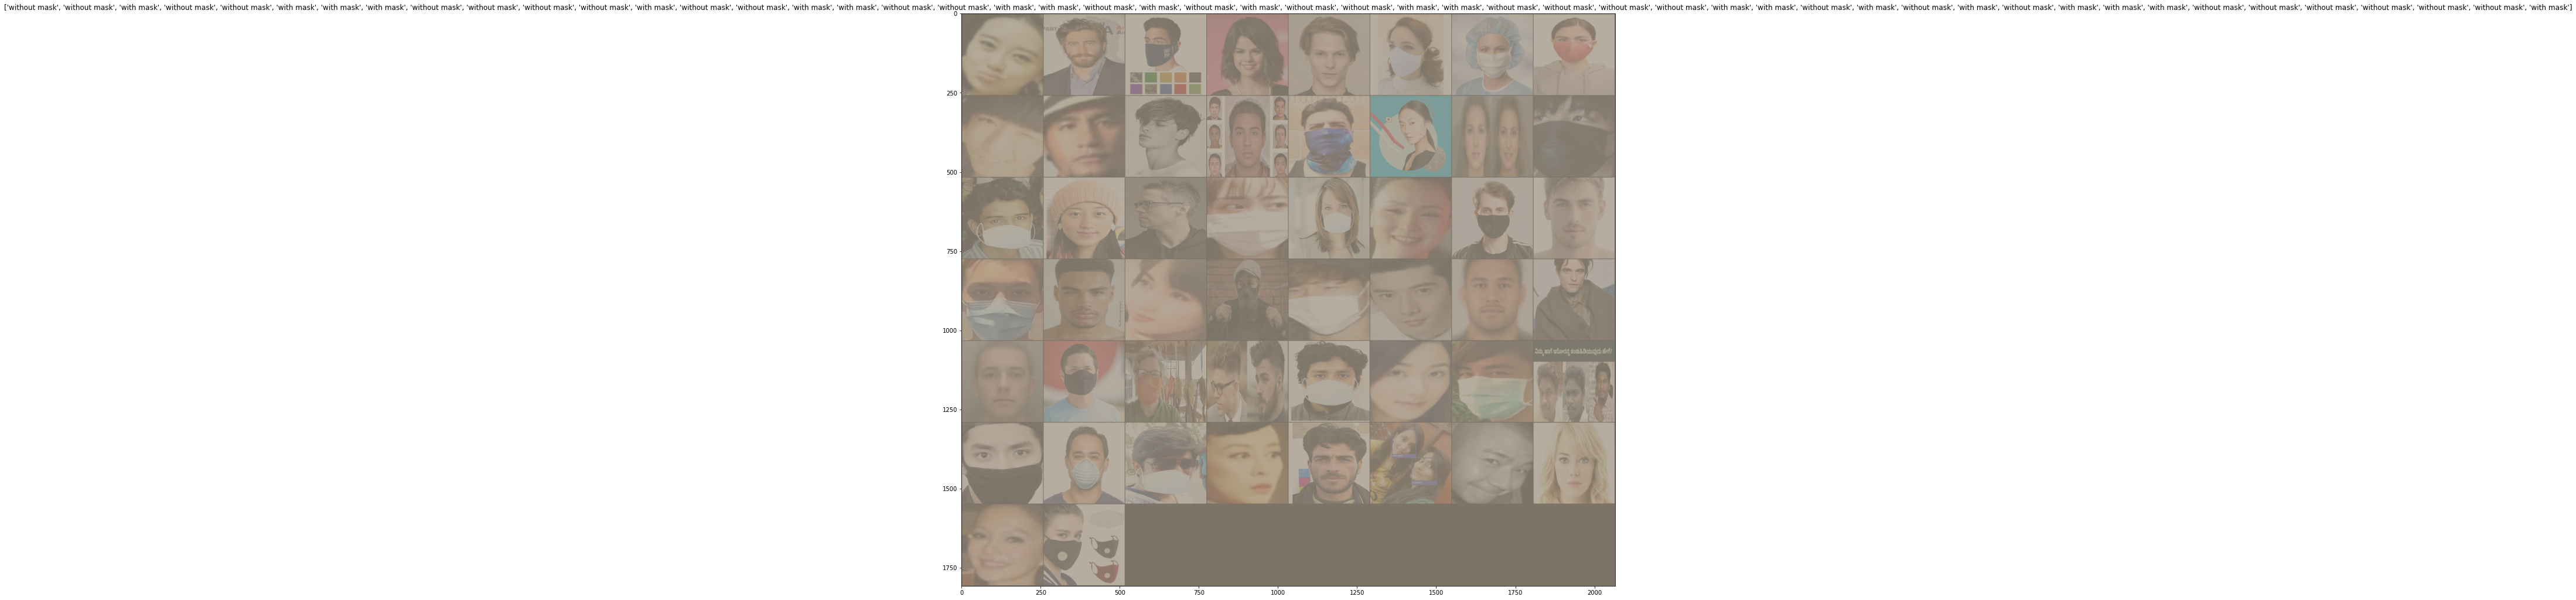

In [ ]:
imshow(out, title=[class_names[x] for x in classes])

# 3. Train Routine

In [3]:
def train(model, trian_loader, val_loader, optimizer, criterion, numEpochs = 10):
    model.train()

    for epoch in range(numEpochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_loader):
            feats, labels = feats.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(feats)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()

            if batch_num % 50 == 0 and batch_num != 0:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
                avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        
        val_loss, val_acc = test_classify(model, val_loader, criterion)
        train_loss, train_acc = test_classify(model, train_loader, criterion)
        print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
              format(train_loss, train_acc, val_loss, val_acc))
        if epoch%5 == 0 and epoch != 0:
            state = {
                "model": model,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            }

            torch.save(state, f'/content/drive/MyDrive/Models/ICS-381_Project/pytorch_model/model_epoch_{epoch}.pt')
            print(f"Model for epoch = {epoch} is saved")


def test_classify(model, test_loader, criterion):
    model.eval()
    test_loss = []
    accuracy = 0
    total = 0

    for batch_num, (feats, labels) in enumerate(test_loader):
        feats, labels = feats.to(device), labels.to(device)
        outputs = model(feats)
        
        _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
        pred_labels = pred_labels.view(-1)
        
        loss = criterion(outputs, labels.long())
        
        accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)
        test_loss.extend([loss.item()]*feats.size()[0])
        del feats
        del labels

    model.train()
    return np.mean(test_loss), accuracy/total

# 4. Network

In [4]:
class Network(nn.Module):
    def __init__(self, CNN_layers, CNN_layers_output, num_classes):
        super(Network, self).__init__()
        
        self.layers = []
        self.layers = nn.Sequential(*CNN_layers)

        self.linear_label = nn.Linear(CNN_layers_output, num_classes, bias=False)
    
    def forward(self, x, evalMode=False):
        output = x
        output = self.layers(output)
        output = F.avg_pool2d(output, [output.size(2), output.size(3)], stride=1)
        output = output.reshape(output.shape[0], output.shape[1])
        
        label_output = self.linear_label(output)
        label_output = label_output/torch.norm(self.linear_label.weight, dim=1)

        return label_output

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)

### 4.1 Net1 (Resnet18)

In [6]:
num_classes = 2

In [7]:
resnet18 = models.resnet18()

net1_CNN_layers = list(resnet18.children())[:-1]

net1_CNN_layers_output = net1_CNN_layers[-2][-1].bn2.num_features

net1 = Network(net1_CNN_layers, net1_CNN_layers_output, num_classes)

net1_criterion_label = nn.CrossEntropyLoss()
net1_optimizer_label = torch.optim.SGD(net1.parameters(), lr=1e-2, weight_decay=5e-5, momentum=0.9)

net1.apply(init_weights)

print(net1)

Network(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


# 5. Train

In [ ]:
epoch = 11

### 5.1 Train Net1 (Resnet18)

In [ ]:
net1.train()
net1.to(device)
train(net1, train_loader, val_loader, net1_optimizer_label, net1_criterion_label, numEpochs = epoch)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 1	Batch: 51	Avg-Loss: 0.5246
Epoch: 1	Batch: 101	Avg-Loss: 0.2708


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train Loss: 1.8241	Train Accuracy: 0.6278	Val Loss: 1.8555	Val Accuracy: 0.6311
Epoch: 2	Batch: 51	Avg-Loss: 0.2130


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 2	Batch: 101	Avg-Loss: 0.1976


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train Loss: 0.7168	Train Accuracy: 0.7585	Val Loss: 0.7298	Val Accuracy: 0.7511


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 3	Batch: 51	Avg-Loss: 0.1482
Epoch: 3	Batch: 101	Avg-Loss: 0.1509


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train Loss: 0.1238	Train Accuracy: 0.9537	Val Loss: 0.1576	Val Accuracy: 0.9457
Epoch: 4	Batch: 51	Avg-Loss: 0.1190


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 4	Batch: 101	Avg-Loss: 0.0987


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train Loss: 0.1776	Train Accuracy: 0.9298	Val Loss: 0.2319	Val Accuracy: 0.9082
Epoch: 5	Batch: 51	Avg-Loss: 0.1101


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 5	Batch: 101	Avg-Loss: 0.0877


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train Loss: 0.0655	Train Accuracy: 0.9796	Val Loss: 0.1184	Val Accuracy: 0.9572


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 6	Batch: 51	Avg-Loss: 0.0729
Epoch: 6	Batch: 101	Avg-Loss: 0.0736


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train Loss: 0.1277	Train Accuracy: 0.9504	Val Loss: 0.2065	Val Accuracy: 0.9188
Model for epoch = 5 is saved
Epoch: 7	Batch: 51	Avg-Loss: 0.0601


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 7	Batch: 101	Avg-Loss: 0.0488


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train Loss: 0.0587	Train Accuracy: 0.9809	Val Loss: 0.1325	Val Accuracy: 0.9576


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 8	Batch: 51	Avg-Loss: 0.0447
Epoch: 8	Batch: 101	Avg-Loss: 0.0485


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train Loss: 0.0342	Train Accuracy: 0.9898	Val Loss: 0.1270	Val Accuracy: 0.9660
Epoch: 9	Batch: 51	Avg-Loss: 0.0247


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 9	Batch: 101	Avg-Loss: 0.0199


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train Loss: 0.0106	Train Accuracy: 0.9970	Val Loss: 0.1169	Val Accuracy: 0.9709


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 10	Batch: 51	Avg-Loss: 0.0310
Epoch: 10	Batch: 101	Avg-Loss: 0.0441


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train Loss: 0.0983	Train Accuracy: 0.9701	Val Loss: 0.2597	Val Accuracy: 0.9413
Epoch: 11	Batch: 51	Avg-Loss: 0.0379


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 11	Batch: 101	Avg-Loss: 0.0400


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train Loss: 0.0768	Train Accuracy: 0.9697	Val Loss: 0.1839	Val Accuracy: 0.9395
Model for epoch = 10 is saved


# 6. Load Model

### 6.1 Load Net1 (Resnet18)

In [8]:
load_epoch = 10
net1_state = torch.load(f"/content/drive/MyDrive/Models/ICS-381_Project/pytorch_model/model_epoch_{load_epoch}.pt")

net1_loaded = net1_state["model"]

print(f"train_loss = {round(net1_state['train_loss'], 2)}, train_acc = {round(net1_state['train_acc'], 2) * 100}")
print(f"val_loss   = {round(net1_state['val_loss'], 2)},   val_acc   = {round(net1_state['val_acc'], 2) * 100}")

train_loss = 0.08, train_acc = 97.0
val_loss   = 0.18,   val_acc   = 94.0


# 7. Test Model

In [ ]:
def test_model(model, img_path, data_transforms):
    #Load the model to the GPU
    model.to(device)
    model.eval()

    #Read the image at path img_path
    img = Image.open(img_path)
    img = data_transforms(img)

    #Show the image
    plt.imshow(img.permute(1,2,0))
    plt.show()

    img = img.unsqueeze(0)

    with torch.no_grad():
        #Load the img to the GPU
        img = img.to(device).float()

        output = model(img)

        _, pred_labels = torch.max(F.softmax(output, dim=1), 1)
        pred_labels = pred_labels.view(-1)

        print(pred_labels)

    if pred_labels == 0:
        print(f"Prediction: with mask")
    else:
        print(f"Prediction: without mask")


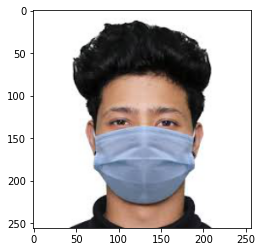

tensor([0])
Prediction: with mask


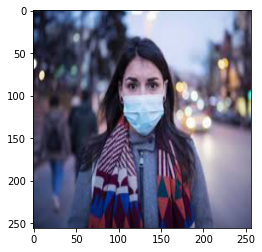

tensor([0])
Prediction: with mask


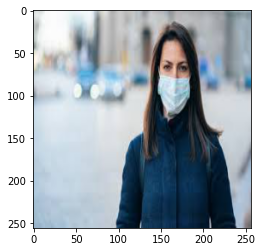

tensor([0])
Prediction: with mask


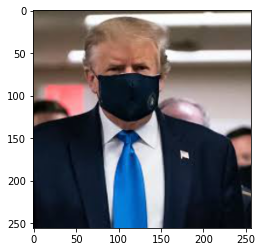

tensor([0])
Prediction: with mask


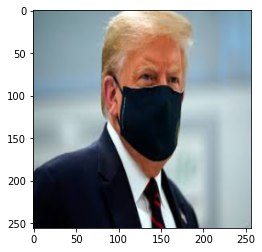

tensor([0])
Prediction: with mask


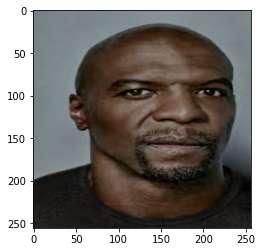

tensor([1])
Prediction: without mask


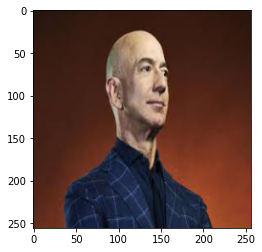

tensor([1])
Prediction: without mask


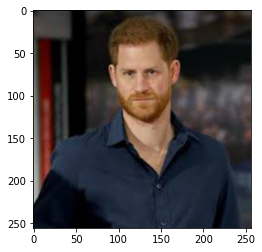

tensor([1])
Prediction: without mask


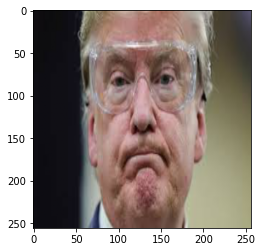

tensor([1])
Prediction: without mask


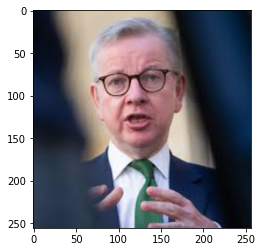

tensor([1])
Prediction: without mask


In [ ]:
new_size = 256
 
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((new_size,new_size))])

paths = ["/content/drive/MyDrive/Data/ICS-381_Project/with_mask1.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask2.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask3.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask4.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/with_mask5.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask1.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask2.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask3.jfif",
        "/content/drive/MyDrive/Data/ICS-381_Project/without_mask4.jfif",
         "/content/drive/MyDrive/Data/ICS-381_Project/without_mask5.jfif"]

for path in paths:
    test_model(net1_loaded, path, data_transforms)